In [221]:
import numpy as np
import pandas as pd

from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import scipy.stats as stats

In [222]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

# 0. Carga de los datos

In [223]:
import os 
ruta = os.getcwd()
print(ruta)

/Users/duman/Documents/universidad/7semestre/BI/BI-202302/Lab2


In [224]:
df_laptops_train = pd.read_csv('./data/laptop_data_train.csv', sep=',', encoding='utf-8')

In [225]:
df_laptops_train.shape

(1216, 14)

In [226]:
df_laptops_train.sample(5)

,id,Company,TypeName,Ram,Weight,Price,TouchScreen,Ips,Ppi,Cpu_brand,HDD,SSD,Gpu_brand,Os
804,74,Acer,Notebook,8,2.10,9.939140,0,0,111.935204,Intel Core i3,1000.0,0,Intel,Windows
788,427,Dell,Ultrabook,8,1.60,10.977717,0,0,157.350512,Intel Core i7,0.0,256,Intel,Others
1201,339,Dell,Notebook,8,2.00,11.016754,0,0,141.211998,Intel Core i5,0.0,256,Nvidia,Windows
995,150,Dell,Gaming,16,2.56,11.105868,0,0,141.211998,Intel Core i7,0.0,512,Nvidia,Windows
939,252,Asus,Notebook,4,1.68,10.126164,0,0,100.454670,AMD Processor,1000.0,0,AMD,Windows


In [230]:
df_laptops_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1216 entries, 0 to 1215
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           1216 non-null   int64  
 1   Company      1216 non-null   object 
 2   TypeName     1216 non-null   object 
 3   Ram          1216 non-null   int64  
 4   Weight       1193 non-null   float64
 5   Price        1201 non-null   float64
 6   TouchScreen  1216 non-null   int64  
 7   Ips          1216 non-null   int64  
 8   Ppi          1204 non-null   float64
 9   Cpu_brand    1216 non-null   object 
 10  HDD          1200 non-null   float64
 11  SSD          1216 non-null   int64  
 12  Gpu_brand    1216 non-null   object 
 13  Os           1216 non-null   object 
dtypes: float64(4), int64(5), object(5)
memory usage: 133.1+ KB


In [231]:
df_laptops_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1216 entries, 0 to 1215
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           1216 non-null   int64  
 1   Company      1216 non-null   object 
 2   TypeName     1216 non-null   object 
 3   Ram          1216 non-null   int64  
 4   Weight       1193 non-null   float64
 5   Price        1201 non-null   float64
 6   TouchScreen  1216 non-null   int64  
 7   Ips          1216 non-null   int64  
 8   Ppi          1204 non-null   float64
 9   Cpu_brand    1216 non-null   object 
 10  HDD          1200 non-null   float64
 11  SSD          1216 non-null   int64  
 12  Gpu_brand    1216 non-null   object 
 13  Os           1216 non-null   object 
dtypes: float64(4), int64(5), object(5)
memory usage: 133.1+ KB


# 1. Entendimiento y limpieza de los datos

In [232]:
# Eleccion de variables relevantes para calcular el precio de un computador
features = [
    'Company',
    'TypeName',
    'Ram',
    'Weight',
    'TouchScreen',
    'Ips',
    'Ppi',
    'Cpu_brand',
    'HDD',
    'SSD',
    'Gpu_brand',
    'Os'
]
featuresCategoricas = ['Company', 'TypeName', 'TouchScreen', 'Ips', 'Cpu_brand', 'Gpu_brand', 'Os']
featuresNumericas = ['Ram', 'Weight', 'Ppi', 'HDD', 'SSD']

# Eliminar variables no en features (id)
df_laptops_train = df_laptops_train[['Price'] + features]


### 1.1. Verificacion de atributos de calidad de datos

#### Consistencia: Valores únicos en las variables categóricas

In [233]:
# verificar valores unicos en cada variable categorica
for feature in featuresCategoricas:
    print(f'{feature}: {df_laptops_train[feature].unique()}')

Company: ['Lenovo' 'Dell' 'HP' 'Asus' 'Toshiba' 'Acer' 'MSI' 'Razer' 'Samsung'
 'Chuwi' 'Microsoft' 'Mediacom' 'LG' 'Vero' 'Apple' 'Huawei' 'Xiaomi'
 'Fujitsu' 'Google']
TypeName: ['Notebook' 'Ultrabook' '2 in 1 Convertible' 'Gaming' 'Netbook'
 'Workstation' '2 in 1 Convertible%%' 'Gaming%%' '&&Notebook'
 '&&Ultrabook' 'Notebook%%' '&&Gaming' '&&2 in 1 Convertible']
TouchScreen: [0 1]
Ips: [0 1]
Cpu_brand: ['Intel Core i3' 'Intel Core i5' 'Intel Core i7' 'AMD Processor'
 'Other Intel Processor']
Gpu_brand: ['Intel' 'Nvidia' 'AMD' 'Intel%%' 'Nvidia%%' '&&Intel' '&&Nvidia' 'AMD%%'
 '&&AMD']
Os: ['Others' 'Windows' 'Mac']


**Resultados:** Se puede observar que las variables 'TypeName' y 'Gpu_brand' tienen valores con caracteres extraños. Se procederá a eliminarlos para corregir esta información.

In [234]:
# Eliminar caracteres "&&", "%%", en las variables categoricas 'TypeName' y 'Gpu_brand'
df_laptops_train['TypeName'] = df_laptops_train['TypeName'].str.replace('&&', '').str.replace('%%', '')
df_laptops_train['Gpu_brand'] = df_laptops_train['Gpu_brand'].str.replace('%%', '').str.replace('&&', '')


In [237]:
#Verificación de valores unicos en cada variable categorica luego de eliminar caracteres "&&", "%%"
for feature in featuresCategoricas:
    print(f'{feature}: {df_laptops_train[feature].unique()}')

Company: ['Lenovo' 'Dell' 'HP' 'Asus' 'Toshiba' 'Acer' 'MSI' 'Razer' 'Samsung'
 'Chuwi' 'Microsoft' 'Mediacom' 'LG' 'Vero' 'Apple' 'Huawei' 'Xiaomi'
 'Fujitsu' 'Google']
TypeName: ['Notebook' 'Ultrabook' '2 in 1 Convertible' 'Gaming' 'Netbook'
 'Workstation']
TouchScreen: [0 1]
Ips: [0 1]
Cpu_brand: ['Intel Core i3' 'Intel Core i5' 'Intel Core i7' 'AMD Processor'
 'Other Intel Processor']
Gpu_brand: ['Intel' 'Nvidia' 'AMD']
Os: ['Others' 'Windows' 'Mac']


Se corrigieron los valores con caracteres extraños.

In [239]:
# Función que compara la cantidad de valores únicos en cada variable categorica entre los datos de entrenamiento y los datos de test
def compararValoresUnicos(df_train, df_test, featuresCategoricas):
    for feature in featuresCategoricas:
        print(f'{feature}: {df_train[feature].unique()}')
        print(f'{feature}: {df_test[feature].unique()}')
        print(f'{feature}: {df_train[feature].unique().shape}')
        print(f'{feature}: {df_test[feature].unique().shape}')
        print('------------------------')

compararValoresUnicos(df_laptops_train, df_laptops_unlabeled, featuresCategoricas)
    

Company: ['Lenovo' 'Dell' 'HP' 'Asus' 'Toshiba' 'Acer' 'MSI' 'Razer' 'Samsung'
 'Chuwi' 'Microsoft' 'Mediacom' 'LG' 'Vero' 'Apple' 'Huawei' 'Xiaomi'
 'Fujitsu' 'Google']
Company: ['HP' 'Lenovo' 'MSI' 'Asus' 'Acer' 'Toshiba' 'Dell' 'Mediacom']
Company: (19,)
Company: (8,)
------------------------
TypeName: ['Notebook' 'Ultrabook' '2 in 1 Convertible' 'Gaming' 'Netbook'
 'Workstation']
TypeName: ['Notebook' 'Gaming' 'Ultrabook' '2 in 1 Convertible' 'Netbook']
TypeName: (6,)
TypeName: (5,)
------------------------
TouchScreen: [0 1]
TouchScreen: [0 1]
TouchScreen: (2,)
TouchScreen: (2,)
------------------------
Ips: [0 1]
Ips: [0 1]
Ips: (2,)
Ips: (2,)
------------------------
Cpu_brand: ['Intel Core i3' 'Intel Core i5' 'Intel Core i7' 'AMD Processor'
 'Other Intel Processor']
Cpu_brand: ['Intel Core i3' 'Intel Core i5' 'Intel Core i7' 'Other Intel Processor'
 'AMD Processor']
Cpu_brand: (5,)
Cpu_brand: (5,)
------------------------
Gpu_brand: ['Intel' 'Nvidia' 'AMD']
Gpu_brand: ['Intel' 

Se puede observar que el dataset de entrenamiento tiene más valores únicos en varias categorías que el dataset de prueba. Se procede a eliminar los valores únicos del dataset de entrenamiento que no se encuentran en el dataset de prueba. 

#### Completitud: Revisar valores nulos

In [240]:
# Revisión del porcentaje de valores nulos (vacíos) en cada columna

df_laptops_train[['Price']+ features].isnull().sum() / df_laptops_train.shape[0]

Price          0.012336
Company        0.000000
TypeName       0.000000
Ram            0.000000
Weight         0.018914
TouchScreen    0.000000
Ips            0.000000
Ppi            0.009868
Cpu_brand      0.000000
HDD            0.013158
SSD            0.000000
Gpu_brand      0.000000
Os             0.000000
dtype: float64

In [241]:
# Eliminar entradas con datos vacíos
# Antes de realizar el drop, se genera un informe con los datos que se van a eliminar
# .isnull() es igual a .isna()
entradas_a_eliminar = df_laptops_train[df_laptops_train[['Price']+ features].isna().any(axis=1)]
entradas_a_eliminar.to_csv('./data/entradas_a_eliminar.csv', sep=',', encoding='utf-8', index=False)

#conocer entradas eliminadas
entradas_a_eliminar.shape

(46, 13)

In [242]:
# Eliminar entradas con datos vacíos
df_laptops_train = df_laptops_train.dropna(subset=['Price']+ features)


In [266]:
df_laptops_train.shape

(1166, 13)

In [245]:
df_laptops_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1170 entries, 0 to 1215
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Price        1170 non-null   float64
 1   Company      1170 non-null   object 
 2   TypeName     1170 non-null   object 
 3   Ram          1170 non-null   int64  
 4   Weight       1170 non-null   float64
 5   TouchScreen  1170 non-null   int64  
 6   Ips          1170 non-null   int64  
 7   Ppi          1170 non-null   float64
 8   Cpu_brand    1170 non-null   object 
 9   HDD          1170 non-null   float64
 10  SSD          1170 non-null   int64  
 11  Gpu_brand    1170 non-null   object 
 12  Os           1170 non-null   object 
dtypes: float64(4), int64(4), object(5)
memory usage: 128.0+ KB


In [247]:
# Revisión del porcentaje de valores nulos (vacíos) en cada columna luego de eliminar entradas con datos vacíos
df_laptops_train[['Price']+ features].isnull().sum() / df_laptops_train.shape[0]

Price          0.0
Company        0.0
TypeName       0.0
Ram            0.0
Weight         0.0
TouchScreen    0.0
Ips            0.0
Ppi            0.0
Cpu_brand      0.0
HDD            0.0
SSD            0.0
Gpu_brand      0.0
Os             0.0
dtype: float64

#### Unicidad: Entradas iguales en todas sus variables

In [249]:
# Unicidad de los datos de entrenamiento
entradas_duplicadas_train = df_laptops_train[df_laptops_train.duplicated()]
len(entradas_duplicadas_train)

4

In [251]:
# Eliminar entradas duplicadas en datos de entrenamiento. 
# No se encontraron duplicados en datos unlabeled
df_laptops_train = df_laptops_train.drop_duplicates()


In [252]:
# Revisión de entradas duplicadas luego de eliminarlas
entradas_duplicadas = df_laptops_train[df_laptops_train.duplicated()]
len(entradas_duplicadas)

0

#### Validez: Rango lógico y formato correcto de valores en variables numéricas

In [253]:
# Revisar la validez de los datos de las variables numericas y la variable price en el dataset de entrenamiento
df_laptops_train[featuresNumericas + ['Price']].describe()


,Ram,Weight,Ppi,HDD,SSD,Price
count,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000
mean,8.507719,2.132753,151.778302,414.802744,187.989708,12.385126
std,5.136040,2.882080,181.493944,517.624081,187.302367,24.476793
min,2.000000,0.690000,90.583402,0.000000,0.000000,9.134616
25%,4.000000,1.500000,127.335675,0.000000,0.000000,10.402328
50%,8.000000,2.040000,141.211998,0.000000,256.000000,10.882316
75%,8.000000,2.310000,157.350512,1000.000000,256.000000,11.288115
max,64.000000,97.729949,6170.032609,2000.000000,1024.000000,499.766079


Encontramos valores atípicos para las variables Weight y Ppi. Procedemos a reemplazarlos por la mediana.

In [254]:
# Revisamos la cantidad de valores atípicos que tiene la variable Ppi, estos son los mayores a 400. 
df_valores_atipicos_ppi = df_laptops_train[df_laptops_train['Ppi'] > 400]
df_valores_atipicos_ppi

,Price,Company,TypeName,Ram,Weight,TouchScreen,Ips,Ppi,Cpu_brand,HDD,SSD,Gpu_brand,Os
364,10.50498,Lenovo,Notebook,4,2.05,0,0,6170.032609,Intel Core i5,500.0,0,Intel,Windows


In [255]:
# Los reemplazamos con la mediana
df_laptops_train.loc[df_laptops_train['Ppi'] > 400, 'Ppi'] = df_laptops_train['Ppi'].median()

In [256]:
# Volvemos a revisar la cantidad de valores atípicos que tiene la variable Ppi, estos son los mayores a 400.
df_valores_atipicos_ppi = df_laptops_train[df_laptops_train['Ppi'] > 400]
len(df_valores_atipicos_ppi)

0

In [257]:
# Mismo proceso con la variabale Weight
df_valores_atipicos_weight = df_laptops_train[df_laptops_train['Weight'] > 5]
df_valores_atipicos_weight

,Price,Company,TypeName,Ram,Weight,TouchScreen,Ips,Ppi,Cpu_brand,HDD,SSD,Gpu_brand,Os
633,10.565862,Dell,Notebook,8,97.729949,0,0,141.211998,Intel Core i5,0.0,256,AMD,Windows


In [258]:
# Reemplazamos los valores atípicos con la mediana
df_laptops_train.loc[df_laptops_train['Weight'] > 5, 'Weight'] = df_laptops_train['Weight'].median()
# Volvemos a revisar la cantidad de valores atípicos que tiene la variable Weight, estos son los mayores a 5.
len(df_laptops_train[df_laptops_train['Weight'] > 5])

0

Volvemos a comprobar los datos de las variables numericas y la variable price para comprobar que no hayan valores atipicos


In [261]:
df_laptops_train[featuresNumericas + ['Price']].describe()

,Ram,Weight,Ppi,HDD,SSD,Price
count,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000
mean,8.507719,2.050686,146.607787,414.802744,187.989708,12.385126
std,5.136040,0.674661,42.705848,517.624081,187.302367,24.476793
min,2.000000,0.690000,90.583402,0.000000,0.000000,9.134616
25%,4.000000,1.500000,127.335675,0.000000,0.000000,10.402328
50%,8.000000,2.040000,141.211998,0.000000,256.000000,10.882316
75%,8.000000,2.310000,157.350512,1000.000000,256.000000,11.288115
max,64.000000,4.700000,352.465147,2000.000000,1024.000000,499.766079


### Output del archivo actual

In [263]:
nombre_archivo = 'df_laptops_train_output1.csv'
df_laptops_train.to_csv('./data/' + nombre_archivo, sep=',', encoding='utf-8', index=False)


#####

# 2. Búsqueda de relaciones entre variables

In [324]:
# Transformar variables categoricas a numericas usando OneHotEncoder
ohe = OneHotEncoder(drop='first', sparse_output=False)


In [335]:
# Ajustar el encoder con los datos de entrenamiento
df_encoded_train = ohe.fit_transform(df_laptops_train[featuresCategoricas])



In [336]:
# Convertir los resultados en DataFrame
df_encoded_train = pd.DataFrame(df_encoded_train, columns=ohe.get_feature_names_out(featuresCategoricas))


In [337]:
# Revisar el resultado
# df_encoded_train.head()


,Company_Apple,Company_Asus,Company_Chuwi,Company_Dell,Company_Fujitsu,Company_Google,Company_HP,Company_Huawei,Company_LG,Company_Lenovo,Company_MSI,Company_Mediacom,Company_Microsoft,Company_Razer,Company_Samsung,Company_Toshiba,Company_Vero,Company_Xiaomi,TypeName_Gaming,TypeName_Netbook,TypeName_Notebook,TypeName_Ultrabook,TypeName_Workstation,TouchScreen_1,Ips_1,Cpu_brand_Intel Core i3,Cpu_brand_Intel Core i5,Cpu_brand_Intel Core i7,Cpu_brand_Other Intel Processor,Gpu_brand_Intel,Gpu_brand_Nvidia,Os_Others,Os_Windows
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [339]:
# back up de los datos de entrenamiento y no etiquetados
df_laptops_train_backup = df_laptops_train.copy()

# Volver a back up de los datos de entrenamiento y no etiquetados
#df_laptops_train = df_laptops_train_backup.copy()


In [340]:
# Concatenar los datos numericos con los datos categoricos codificados

# Resetear los indices de los dataframes de datos etiquetados
df_laptops_train = df_laptops_train.reset_index(drop=True)
df_encoded_train = df_encoded_train.reset_index(drop=True)
# Concatenar los dataframes
df_laptops_train_copy = pd.concat([df_laptops_train.drop(featuresCategoricas, axis=1), df_encoded_train], axis=1)





In [341]:
# Verificar que no hayan valores nulos en los datos de entrenamiento
rows_with_nan = df_laptops_train_copy[df_laptops_train_copy.isnull().any(axis=1)]
rows_with_nan


,Price,Ram,Weight,Ppi,HDD,SSD,Company_Apple,Company_Asus,Company_Chuwi,Company_Dell,Company_Fujitsu,Company_Google,Company_HP,Company_Huawei,Company_LG,Company_Lenovo,Company_MSI,Company_Mediacom,Company_Microsoft,Company_Razer,Company_Samsung,Company_Toshiba,Company_Vero,Company_Xiaomi,TypeName_Gaming,TypeName_Netbook,TypeName_Notebook,TypeName_Ultrabook,TypeName_Workstation,TouchScreen_1,Ips_1,Cpu_brand_Intel Core i3,Cpu_brand_Intel Core i5,Cpu_brand_Intel Core i7,Cpu_brand_Other Intel Processor,Gpu_brand_Intel,Gpu_brand_Nvidia,Os_Others,Os_Windows


In [342]:
df_laptops_train_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1166 entries, 0 to 1165
Data columns (total 39 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Price                            1166 non-null   float64
 1   Ram                              1166 non-null   int64  
 2   Weight                           1166 non-null   float64
 3   Ppi                              1166 non-null   float64
 4   HDD                              1166 non-null   float64
 5   SSD                              1166 non-null   int64  
 6   Company_Apple                    1166 non-null   float64
 7   Company_Asus                     1166 non-null   float64
 8   Company_Chuwi                    1166 non-null   float64
 9   Company_Dell                     1166 non-null   float64
 10  Company_Fujitsu                  1166 non-null   float64
 11  Company_Google                   1166 non-null   float64
 12  Company_HP          

#### Se comprueba el supuesto de correlación entre las variables independientes numéricas.
Se acepta un nivel de correlación menor a ~$|0.8|$.

,Ram,Weight,Ppi,HDD,SSD
Ram,1.000000,0.401434,0.290125,0.088890,0.596536
Weight,0.401434,1.000000,-0.314977,0.510444,-0.049636
Ppi,0.290125,-0.314977,1.000000,-0.298250,0.501579
HDD,0.088890,0.510444,-0.298250,1.000000,-0.403111
SSD,0.596536,-0.049636,0.501579,-0.403111,1.000000


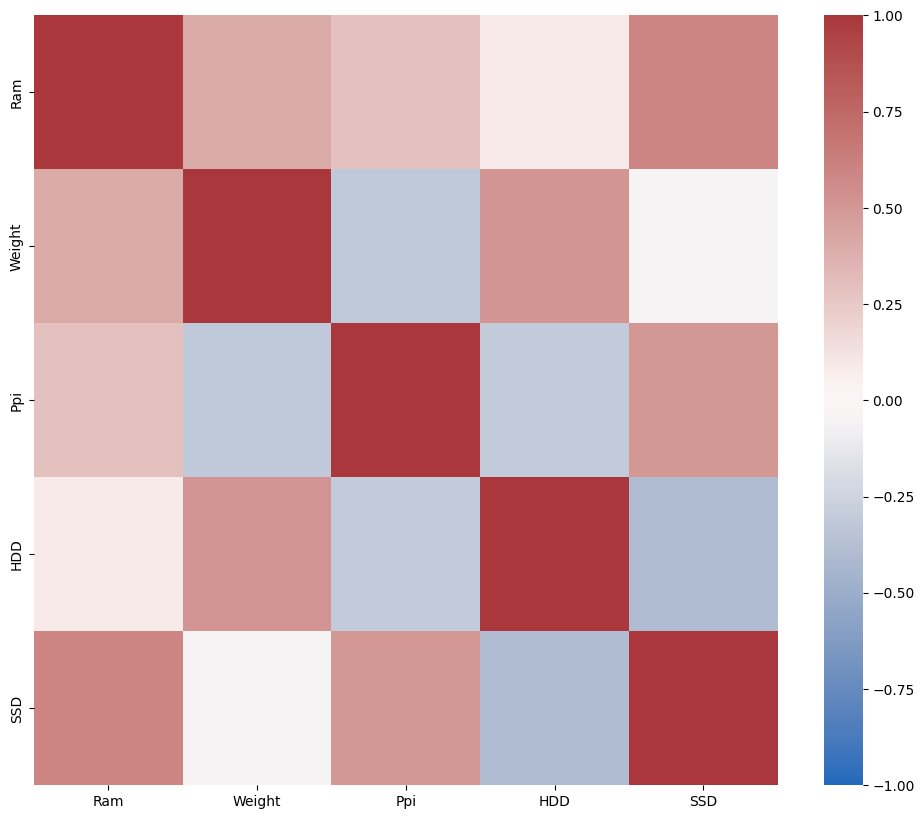

In [291]:

# Correlacion entre variables numericas
plt.figure(figsize = (12, 10))
sns.heatmap(df_laptops_train[featuresNumericas].corr(), cmap = 'vlag', vmin = -1, vmax = 1)
df_laptops_train[featuresNumericas].corr()


Se verifica efectivamente, que no existe correlación entre las variables numericas.

#### Normalización de las variables

In [344]:
scaler = StandardScaler()

# Ajustar el scaler con los datos de entrenamiento
scaler.fit(df_laptops_train_copy[featuresNumericas])

StandardScaler()

In [345]:
### Warning ###
# Backup de los datos de entrenamiento y test
df_laptops_train_copy_backup = df_laptops_train_copy.copy()


In [346]:
# vistazo al backup si hay valores nulos
rows_with_nan = df_laptops_train_copy_backup[df_laptops_train_copy_backup.isnull().any(axis=1)]
rows_with_nan


,Price,Ram,Weight,Ppi,HDD,SSD,Company_Apple,Company_Asus,Company_Chuwi,Company_Dell,Company_Fujitsu,Company_Google,Company_HP,Company_Huawei,Company_LG,Company_Lenovo,Company_MSI,Company_Mediacom,Company_Microsoft,Company_Razer,Company_Samsung,Company_Toshiba,Company_Vero,Company_Xiaomi,TypeName_Gaming,TypeName_Netbook,TypeName_Notebook,TypeName_Ultrabook,TypeName_Workstation,TouchScreen_1,Ips_1,Cpu_brand_Intel Core i3,Cpu_brand_Intel Core i5,Cpu_brand_Intel Core i7,Cpu_brand_Other Intel Processor,Gpu_brand_Intel,Gpu_brand_Nvidia,Os_Others,Os_Windows


In [347]:
# Transformar los conjuntos de datos
df_laptops_train_copy[featuresNumericas] = scaler.transform(df_laptops_train_copy[featuresNumericas])


In [348]:
df_laptops_train_copy.head()

,Price,Ram,Weight,Ppi,HDD,SSD,Company_Apple,Company_Asus,Company_Chuwi,Company_Dell,Company_Fujitsu,Company_Google,Company_HP,Company_Huawei,Company_LG,Company_Lenovo,Company_MSI,Company_Mediacom,Company_Microsoft,Company_Razer,Company_Samsung,Company_Toshiba,Company_Vero,Company_Xiaomi,TypeName_Gaming,TypeName_Netbook,TypeName_Notebook,TypeName_Ultrabook,TypeName_Workstation,TouchScreen_1,Ips_1,Cpu_brand_Intel Core i3,Cpu_brand_Intel Core i5,Cpu_brand_Intel Core i7,Cpu_brand_Other Intel Processor,Gpu_brand_Intel,Gpu_brand_Nvidia,Os_Others,Os_Windows
0,10.084809,-0.878041,-0.223447,-1.081185,0.164664,-1.004100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,10.563111,-0.098897,-0.104818,-0.126402,1.131030,-1.004100,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,11.064804,-0.098897,-1.172478,0.693992,-0.801703,0.363260,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,10.977717,0.680248,0.310384,-0.126402,3.063763,1.730621,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,11.550633,-0.098897,-1.246621,4.325770,-0.801703,0.363260,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [349]:
# Revisar el resultado
df_laptops_train_copy.describe()

,Price,Ram,Weight,Ppi,HDD,SSD,Company_Apple,Company_Asus,Company_Chuwi,Company_Dell,Company_Fujitsu,Company_Google,Company_HP,Company_Huawei,Company_LG,Company_Lenovo,Company_MSI,Company_Mediacom,Company_Microsoft,Company_Razer,Company_Samsung,Company_Toshiba,Company_Vero,Company_Xiaomi,TypeName_Gaming,TypeName_Netbook,TypeName_Notebook,TypeName_Ultrabook,TypeName_Workstation,TouchScreen_1,Ips_1,Cpu_brand_Intel Core i3,Cpu_brand_Intel Core i5,Cpu_brand_Intel Core i7,Cpu_brand_Other Intel Processor,Gpu_brand_Intel,Gpu_brand_Nvidia,Os_Others,Os_Windows
count,1166.000000,1.166000e+03,1.166000e+03,1.166000e+03,1.166000e+03,1.166000e+03,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000
mean,12.385126,-1.553931e-16,-2.071908e-16,-3.656309e-17,1.828155e-17,2.437539e-17,0.018010,0.117496,0.001715,0.229846,0.002573,0.002573,0.206690,0.001715,0.001715,0.229846,0.041166,0.005146,0.005146,0.006003,0.006861,0.037736,0.003431,0.003431,0.164666,0.016295,0.552316,0.151801,0.024014,0.143225,0.283019,0.107204,0.325901,0.413379,0.105489,0.546312,0.316467,0.118353,0.863636
std,24.476793,1.000429e+00,1.000429e+00,1.000429e+00,1.000429e+00,1.000429e+00,0.133045,0.322148,0.041398,0.420914,0.050680,0.050680,0.405105,0.041398,0.041398,0.420914,0.198760,0.071580,0.071580,0.077282,0.082582,0.190638,0.058495,0.058495,0.371038,0.126662,0.497469,0.358982,0.153157,0.350452,0.450659,0.309505,0.468911,0.492651,0.307314,0.498064,0.465297,0.323165,0.343322
min,9.134616,-1.267613e+00,-2.017709e+00,-1.312430e+00,-8.017029e-01,-1.004100e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.402328,-8.780408e-01,-8.165913e-01,-4.514694e-01,-8.017029e-01,-1.004100e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,10.882316,-9.889653e-02,-1.584602e-02,-1.264020e-01,-8.017029e-01,3.632601e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,11.288115,-9.889653e-02,3.845266e-01,2.516596e-01,1.131030e+00,3.632601e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000
max,499.766079,1.080912e+01,3.928566e+00,4.822424e+00,3.063763e+00,4.465341e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [350]:
# Revisar unicamente columna Price
df_laptops_train_copy['Price'].describe()

count    1166.000000
mean       12.385126
std        24.476793
min         9.134616
25%        10.402328
50%        10.882316
75%        11.288115
max       499.766079
Name: Price, dtype: float64

# 3. Construcción de modelo de regresión

In [351]:
x_train = df_laptops_train_copy.drop('Price', axis=1)
y_train = df_laptops_train_copy['Price']

In [352]:
# Mostrar filas con valores nulos
x_train[x_train.isnull().any(axis=1)]


,Ram,Weight,Ppi,HDD,SSD,Company_Apple,Company_Asus,Company_Chuwi,Company_Dell,Company_Fujitsu,Company_Google,Company_HP,Company_Huawei,Company_LG,Company_Lenovo,Company_MSI,Company_Mediacom,Company_Microsoft,Company_Razer,Company_Samsung,Company_Toshiba,Company_Vero,Company_Xiaomi,TypeName_Gaming,TypeName_Netbook,TypeName_Notebook,TypeName_Ultrabook,TypeName_Workstation,TouchScreen_1,Ips_1,Cpu_brand_Intel Core i3,Cpu_brand_Intel Core i5,Cpu_brand_Intel Core i7,Cpu_brand_Other Intel Processor,Gpu_brand_Intel,Gpu_brand_Nvidia,Os_Others,Os_Windows


In [353]:
regression = LinearRegression()

In [354]:
# revision de valores NaN existentes en el dataset
x_train.isnull().sum()


Ram                                0
Weight                             0
Ppi                                0
HDD                                0
SSD                                0
Company_Apple                      0
Company_Asus                       0
Company_Chuwi                      0
Company_Dell                       0
Company_Fujitsu                    0
Company_Google                     0
Company_HP                         0
Company_Huawei                     0
Company_LG                         0
Company_Lenovo                     0
Company_MSI                        0
Company_Mediacom                   0
Company_Microsoft                  0
Company_Razer                      0
Company_Samsung                    0
Company_Toshiba                    0
Company_Vero                       0
Company_Xiaomi                     0
TypeName_Gaming                    0
TypeName_Netbook                   0
TypeName_Notebook                  0
TypeName_Ultrabook                 0
T

In [355]:
regression.fit(x_train, y_train)

LinearRegression()

### 3.1. Interpretación de los coeficientes y el intercepto

In [359]:
pd.DataFrame(regression.coef_, index=x_train.columns, columns=['Coeficiente'])

,Coeficiente
Ram,-0.495148
Weight,-1.648570
Ppi,-1.018010
HDD,1.140538
SSD,2.961238
Company_Apple,-0.718228
Company_Asus,0.522249
Company_Chuwi,6.087350
Company_Dell,0.703037
Company_Fujitsu,0.547953


In [360]:
regression.intercept_

0.17121872968212237

In [363]:
# Prueba de significancia individual de las variables. 
# Se utiliza el p-value para determinar si la variable es significativa o no
# Si el p-value es menor a 0.05, la variable es significativa, es decir, tiene un efecto sobre la variable dependiente
# Si el p-value es mayor a 0.05, la variable no es significativa, es decir, no tiene un efecto sobre la variable dependiente


x_train_sm = sm.add_constant(x_train)

model = sm.OLS(y_train, x_train_sm).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.063
Date:                Thu, 14 Sep 2023   Prob (F-statistic):              0.369
Time:                        02:31:35   Log-Likelihood:                -5362.5
No. Observations:                1166   AIC:                         1.080e+04
Df Residuals:                    1128   BIC:                         1.099e+04
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               0.1284      4.575      0.028      0.978      -8.848       9.105
Ram                                -0.4951      1.224     -0.405      0.686      -2.897       1.907
Weight                             -1.6486      1.317     -1.252      0.211      -4.233       0.936
Ppi                                -1.0180      1.049     -0.970      0.332      -3.076       1.040
HDD                                 1.1405      1.021      1.117      0.264      -0.863       3.144
SSD                                 2.9612      1.223      2.421      0.016       0.561       5.361
Company_Apple                      -0.6754      4.820     -0.140      0.889     -10.134       8.783
Company_Asus                        0.5222      3.497      0.149      0.881      -6.338       7.383
Company_Chuwi                       6.0873     17.786      0.342      0.732     -28.810      40.985
Company_Dell                        0.7030      3.252      0.216      0.829      -5.677       7.083
Company_Fujitsu                     0.5480     14.487      0.038      0.970     -27.877      28.973
Company_Google                     -7.1504     15.085     -0.474      0.636     -36.748      22.447
Company_HP                          2.1419      3.146      0.681      0.496      -4.031       8.315
Company_Huawei                     -6.0217     17.699     -0.340      0.734     -40.749      28.705
Company_LG                        -11.8588     17.839     -0.665      0.506     -46.860      23.142
Company_Lenovo                      2.5679      3.048      0.843      0.400      -3.412       8.547
Company_MSI                         1.3927      5.193      0.268      0.789      -8.797      11.583
Company_Mediacom                    3.2943     10.701      0.308      0.758     -17.702      24.290
Company_Microsoft                  -5.4724     11.028     -0.496      0.620     -27.110      16.165
Company_Razer                      -3.5949     10.244     -0.351      0.726     -23.694      16.504
Company_Samsung                    -3.4220      9.312     -0.367      0.713     -21.692      14.848
Company_Toshiba                    -1.8534      4.725     -0.392      0.695     -11.125       7.418
Company_Vero                        4.1960     12.801      0.328      0.743     -20.921      29.313
Company_Xiaomi                     -3.9349     12.864     -0.306      0.760     -29.176      21.306
TypeName_Gaming                     8.4040      5.598      1.501      0.134      -2.580      19.388
TypeName_Netbook                   30.6069      7.256      4.218      0.000      16.370      44.844
TypeName_Notebook                   8.8066      4.531      1.944      0.052      -0.083      17.697
TypeName_Ultrabook                  9.4342      4.438      2.126      0.034       0

Solo 3 de las 36 variables superaron la prueba t. `revisar` #TODO #1